In [1]:
%%capture
!git clone https://github.com/chengtan9907/OpenSTL
!pip install fvcore lightning einops tensorboard
# !pip install fvcore
# !pip install lightning
# !pip install einops
#!pip install -r OpenSTL/requirements.txt

In [2]:
import sys
sys.path.append("OpenSTL")

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

input_path = '/kaggle/input/2024-flame-ai-challenge/dataset/'

train_df = pd.read_csv(os.path.join(input_path,'train.csv'))
test_df = pd.read_csv(os.path.join(input_path,'test.csv'))
test_df.head()

,id,u,alpha,Nt,Nx,Ny,theta_filename,ustar_filename,xi_filename
0,219547,5,2.5,5,113,32,theta_K_id219547.dat,ustar_ms-1_id219547.dat,xi_id219547.dat
1,167403,5,2.5,5,113,32,theta_K_id167403.dat,ustar_ms-1_id167403.dat,xi_id167403.dat
2,225258,5,2.5,5,113,32,theta_K_id225258.dat,ustar_ms-1_id225258.dat,xi_id225258.dat
3,890407,5,25.0,5,113,32,theta_K_id890407.dat,ustar_ms-1_id890407.dat,xi_id890407.dat
4,352206,5,25.0,5,113,32,theta_K_id352206.dat,ustar_ms-1_id352206.dat,xi_id352206.dat


In [3]:
dir_path = input_path+"train"

pre_seq_length = 6
aft_seq_length = 20

X = []

for i,row in train_df.iterrows():
    nt, Nx, Ny = row['Nt'], row['Nx'], row['Ny']
    theta = np.fromfile(os.path.join(dir_path, row['theta_filename']), dtype="<f4").reshape(nt, Nx, Ny)
    ustar = np.fromfile(os.path.join(dir_path, row['ustar_filename']), dtype="<f4").reshape(nt, Nx, Ny)
    xi_f = np.fromfile(os.path.join(dir_path, row['xi_filename']), dtype="<f4").reshape(nt, Nx, Ny)
    uin  = np.array(row['u'])
    alpha = np.array(row['alpha'])
    uin = np.full_like(theta,uin)
    alpha = np.full_like(theta,alpha)

    X.append(np.stack([xi_f,theta/1_000,uin/50,alpha/50,ustar/50],axis=-1))
    
X = np.array(X).transpose(0, 1, 4, 2, 3)
X = np.pad(X, pad_width=((0, 0), (0, 0), (0, 0), (0, 3), (0, 0)), mode='edge')
y = X[:,pre_seq_length:]
X = X[:,:-pre_seq_length]

print(X.shape,y.shape)

from sklearn.model_selection import train_test_split

# Perform the split on the first dimension (9 simulations)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(9, 144, 5, 116, 32) (9, 144, 5, 116, 32)


(7, 144, 5, 116, 32)

In [4]:
def temporal_slicing(X, y, step=1):
    num_simulations, time_steps, height, width, features = X.shape
    num_windows = time_steps - aft_seq_length + 1
    X_sliced = []
    y_sliced = []
    
    for sim in range(num_simulations):
        for start in range(0, num_windows, step):
            X_window = X[sim, start:start+pre_seq_length, ...]
            y_window = y[sim, start:start+aft_seq_length, ...]
            X_sliced.append(X_window)
            y_sliced.append(y_window)
    X_sliced = np.array(X_sliced)
    y_sliced = np.array(y_sliced)
    
    return X_sliced, y_sliced

X_train_sliced, y_train_sliced = temporal_slicing(X_train, y_train)
X_val_sliced, y_val_sliced = temporal_slicing(X_val, y_val)

print("Sliced X_train shape:", X_train_sliced.shape)
print("Sliced y_train shape:", y_train_sliced.shape)
print("Sliced X_val shape:", X_val_sliced.shape)
print("Sliced y_val shape:", y_val_sliced.shape)

Sliced X_train shape: (875, 6, 5, 116, 32)
Sliced y_train shape: (875, 20, 5, 116, 32)
Sliced X_val shape: (250, 6, 5, 116, 32)
Sliced y_val shape: (250, 20, 5, 116, 32)


In [5]:
from torch.utils.data import Dataset,DataLoader

class FireDataset(Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = "custom"

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels
    

batch_size = 32

train_set = FireDataset(X=X_train_sliced, Y=y_train_sliced)
val_set = FireDataset(X=X_val_sliced, Y=y_val_sliced)
test_set = FireDataset(X=X_val_sliced, Y=y_val_sliced)

dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

In [6]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 12,
    'lr': 1e-3,   
    'metrics': ['mse','mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [pre_seq_length,5,116,32],
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'ConvLSTM',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    #'model_type': 'tau',
    'num_hidden': '128,128',
    'filter_size':3,
    'stride':1,
    'patch_size':4,
    'layer_norm':0,
    'reverse_scheduled_sampling':0,
    'scheduled_sampling':1,
    'sampling_stop_iter':900,
    'sampling_start_value':.9,
    'sampling_changing_rate':0.00002,
}

In [7]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test), strategy='auto')

INFO: Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [8]:
exp.train()
exp.test()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | ConvLSTM_Model | 2.8 M  | train
1 | criterion | MSELoss        | 0      | train
-----------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.215    Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_12.3.r12.3/compiler.33567101_0
GPU 0: Tesla P100-PCIE-16GB
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.4.0
PyTorch compiling details: PyTorch built with:
  - GCC 11.4
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2.1-Product Build 20240722 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.4.2 (Git Hash 1137e04ec0b5251ca2b4400a4fd3c667ce843d67)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.3
  - NVCC architecture flags: -gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_70,code=compute_70;-

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 28: 'val_loss' reached 0.01197 (best 0.01197), saving model to '/kaggle/working/work_dirs/custom_exp/checkpoints/best-epoch=00-val_loss=0.012.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 56: 'val_loss' reached 0.00656 (best 0.00656), saving model to '/kaggle/working/work_dirs/custom_exp/checkpoints/best-epoch=01-val_loss=0.007.ckpt' as top 1


Epoch 1: Lr: 0.0006116 | Train Loss: 0.0221623 | Vali Loss: 0.0065574


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 84: 'val_loss' reached 0.00490 (best 0.00490), saving model to '/kaggle/working/work_dirs/custom_exp/checkpoints/best-epoch=02-val_loss=0.005.ckpt' as top 1


Epoch 2: Lr: 0.0009418 | Train Loss: 0.0076449 | Vali Loss: 0.0049044


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 112: 'val_loss' reached 0.00417 (best 0.00417), saving model to '/kaggle/working/work_dirs/custom_exp/checkpoints/best-epoch=03-val_loss=0.004.ckpt' as top 1


Epoch 3: Lr: 0.0009934 | Train Loss: 0.0034401 | Vali Loss: 0.0041674


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 140: 'val_loss' was not in top 1


Epoch 4: Lr: 0.0009296 | Train Loss: 0.0025015 | Vali Loss: 0.0051746


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 168: 'val_loss' reached 0.00332 (best 0.00332), saving model to '/kaggle/working/work_dirs/custom_exp/checkpoints/best-epoch=05-val_loss=0.003.ckpt' as top 1


Epoch 5: Lr: 0.0008065 | Train Loss: 0.0022147 | Vali Loss: 0.0033159


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 196: 'val_loss' reached 0.00304 (best 0.00304), saving model to '/kaggle/working/work_dirs/custom_exp/checkpoints/best-epoch=06-val_loss=0.003.ckpt' as top 1


Epoch 6: Lr: 0.0006410 | Train Loss: 0.0020671 | Vali Loss: 0.0030434


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 224: 'val_loss' was not in top 1


Epoch 7: Lr: 0.0004560 | Train Loss: 0.0019748 | Vali Loss: 0.0030927


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 252: 'val_loss' reached 0.00302 (best 0.00302), saving model to '/kaggle/working/work_dirs/custom_exp/checkpoints/best-epoch=08-val_loss=0.003.ckpt' as top 1


Epoch 8: Lr: 0.0002771 | Train Loss: 0.0019192 | Vali Loss: 0.0030189


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 280: 'val_loss' was not in top 1


Epoch 9: Lr: 0.0001290 | Train Loss: 0.0018834 | Vali Loss: 0.0030226


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 308: 'val_loss' was not in top 1


Epoch 10: Lr: 0.0000322 | Train Loss: 0.0018616 | Vali Loss: 0.0030537


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 336: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=12` reached.


Epoch 11: Lr: 0.0000000 | Train Loss: 0.0018514 | Vali Loss: 0.0030411


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

mse:56.442596435546875, mae:388.6181640625


In [9]:
long = len(X_val_sliced)
X_val_sliced = X_val_sliced[:long]
X_val_sliced[:,0,...] = X_val_sliced[:,1,...]
y_val_sliced = y_val_sliced[:long]

test_set = FireDataset(X=X_val_sliced, Y=y_val_sliced)

dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

exp.data = exp._get_data(dataloaders=(dataloader_test, dataloader_test, dataloader_test))
exp.test()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

mse:56.455223083496094, mae:388.63201904296875


(250, 20, 5, 113, 32)
input:


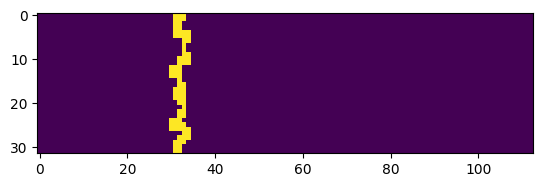

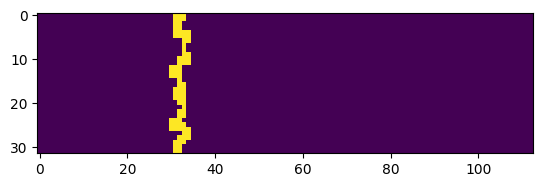

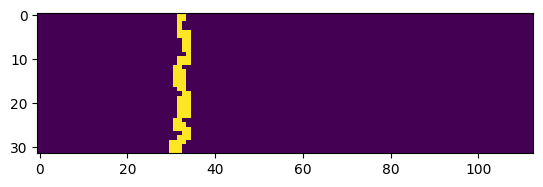

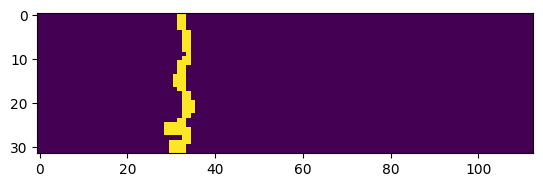

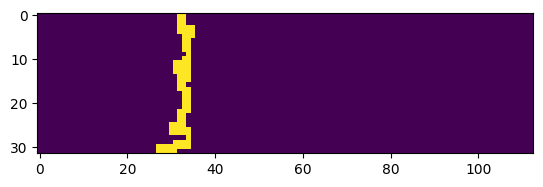

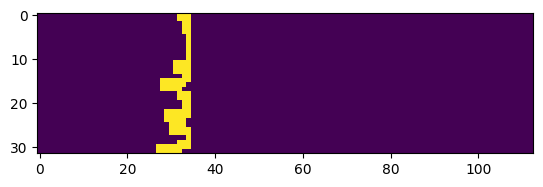

#########################
pred:


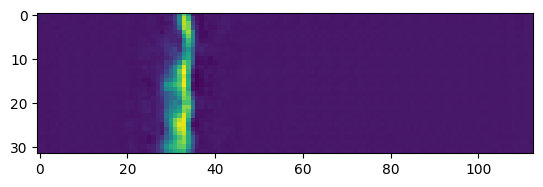

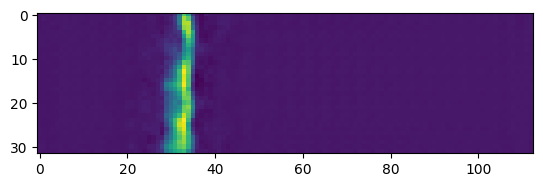

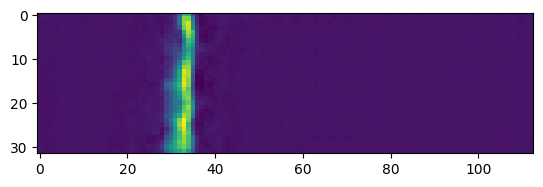

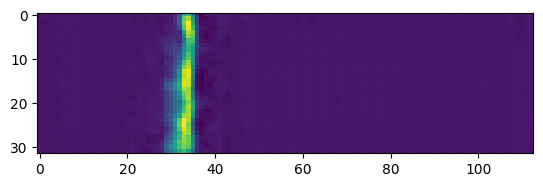

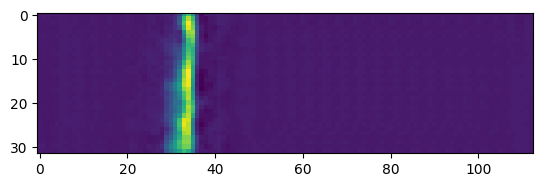

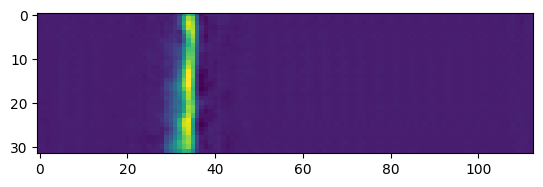

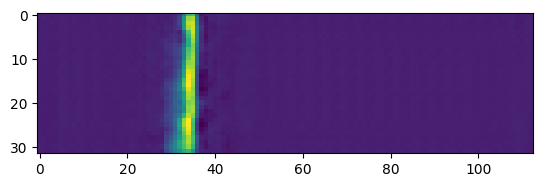

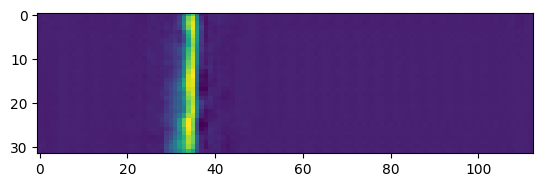

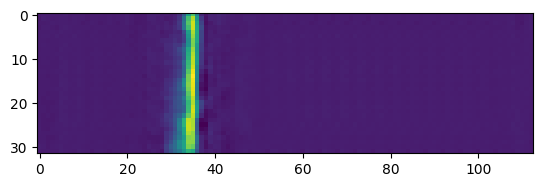

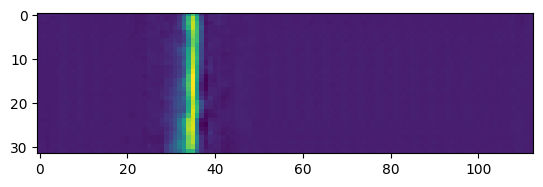

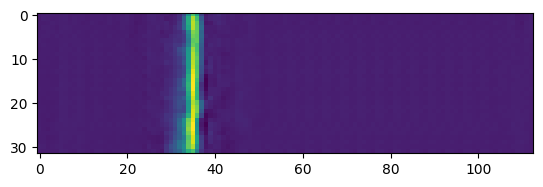

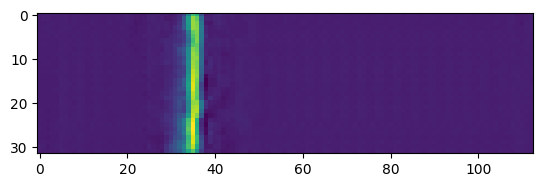

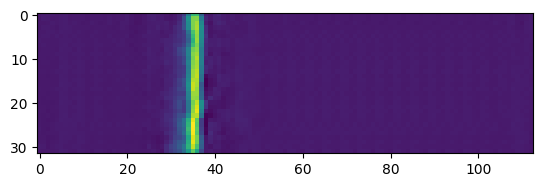

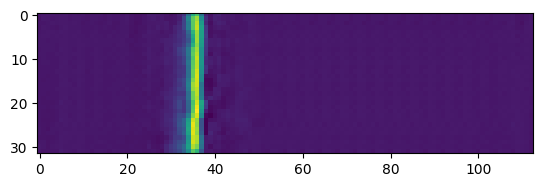

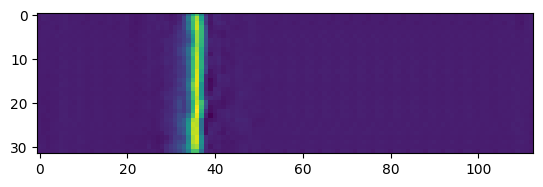

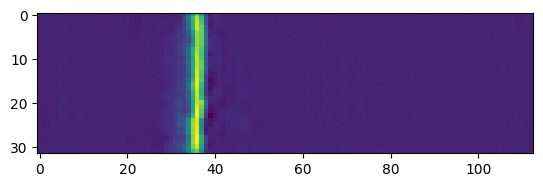

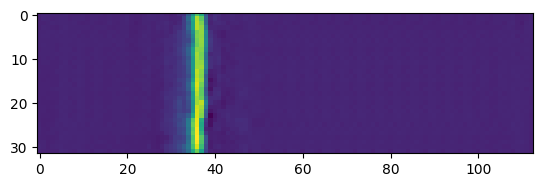

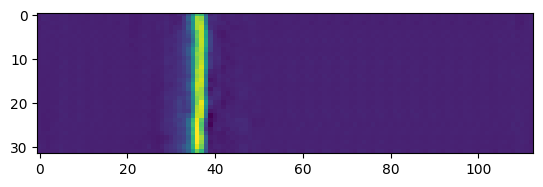

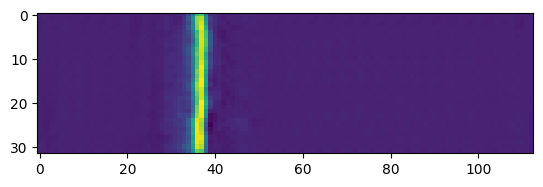

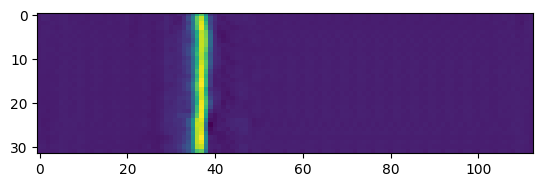

In [10]:
pred = np.load("/kaggle/working/work_dirs/custom_exp/saved/preds.npy")[-long:,:,:,:113,:]
print(pred.shape)

inp = np.load("/kaggle/working/work_dirs/custom_exp/saved/inputs.npy")[-long:,:,:,:113,:]

idx = 200

print("input:")
for i in range(inp.shape[1]):
    plt.imshow(inp[idx,i,0,...].T)
    plt.show()
    
print("#"*25)
print("pred:")
for i in range(pred.shape[1]):
    plt.imshow(pred[idx,i,0,...].T)
    plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

pred = pred[:,:,0,:113,:].flatten()
y_true = y_val_sliced[:,:,0,:113,:].flatten()

print("Validation MSE :",mean_squared_error(pred,y_true))

Validation MSE : 0.012433823


# Sub

In [12]:
dir_path = input_path+"test"

X = []

for i,row in test_df.iterrows():
    nt, Nx, Ny = row['Nt'], row['Nx'], row['Ny']
    theta = np.fromfile(os.path.join(dir_path, row['theta_filename']), dtype="<f4").reshape(nt, Nx, Ny)
    ustar = np.fromfile(os.path.join(dir_path, row['ustar_filename']), dtype="<f4").reshape(nt, Nx, Ny)
    xi_f = np.fromfile(os.path.join(dir_path, row['xi_filename']), dtype="<f4").reshape(nt, Nx, Ny)
    uin  = np.array(row['u'])
    alpha = np.array(row['alpha'])
    uin = np.full_like(theta,uin)
    alpha = np.full_like(theta,alpha)

    X.append(np.stack([xi_f,theta/1_000,uin/50,alpha/50,ustar/50],axis=-1))
    
X_ = np.zeros((27,6,5,116,32))
X = np.array(X).transpose(0, 1, 4, 2, 3)
X = np.pad(X, pad_width=((0, 0), (0, 0), (0, 0), (0, 3), (0, 0)), mode='edge')
X_[:,1:,...] = X[:,...]
X_[:,0,...] = X[:,1,...]
X = X_
X.shape

(27, 6, 5, 116, 32)

In [13]:
test_set = FireDataset(X=X, Y=np.zeros((X.shape[0],20,5,116,32)))

dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

exp.data = exp._get_data(dataloaders=(dataloader_test, dataloader_test, dataloader_test))
exp.test()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

mse:87.2694320678711, mae:509.17742919921875


(27, 20, 5, 113, 32)
input:


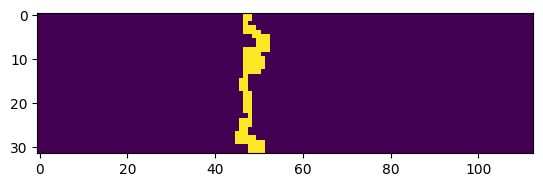

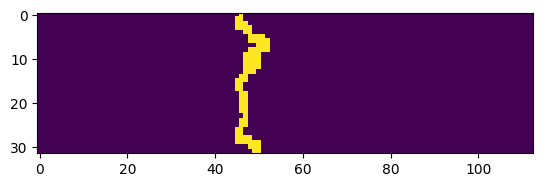

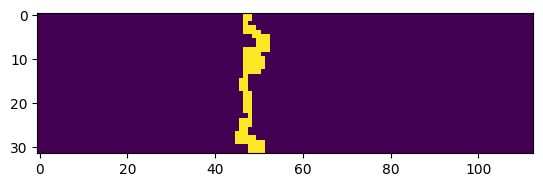

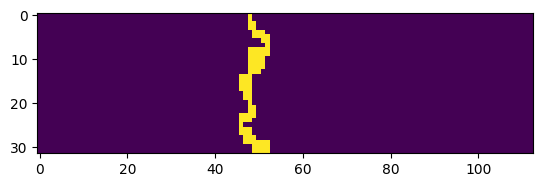

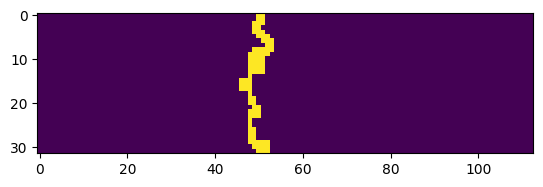

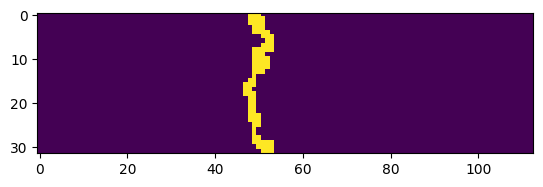

#########################
pred:


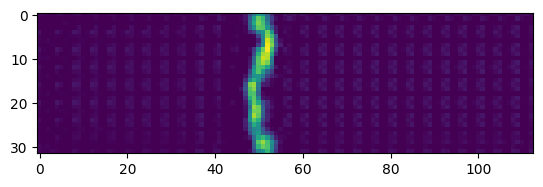

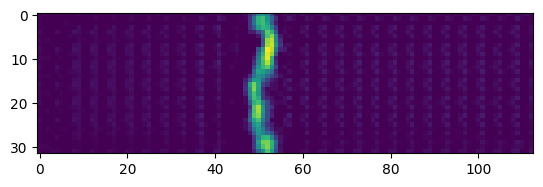

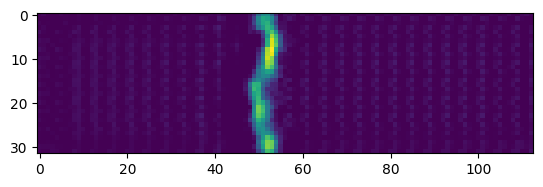

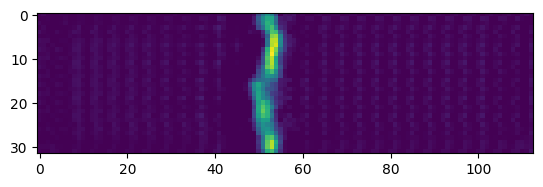

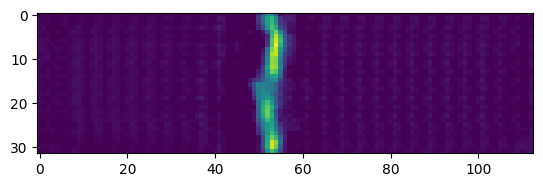

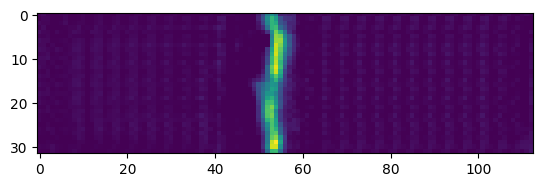

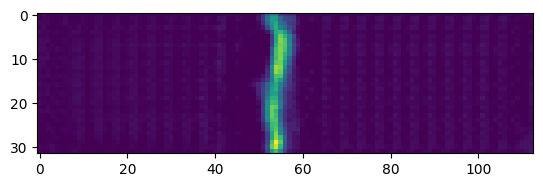

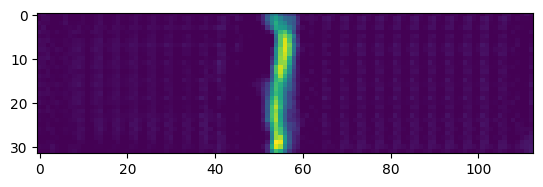

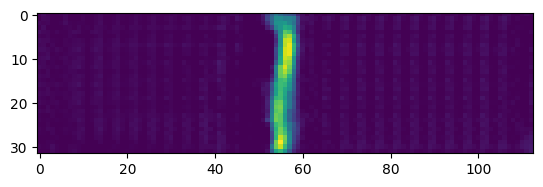

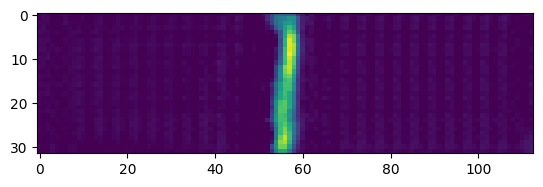

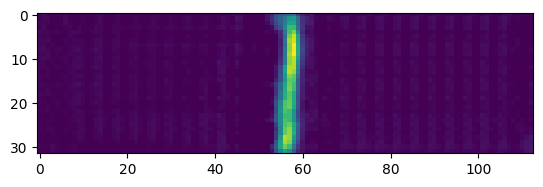

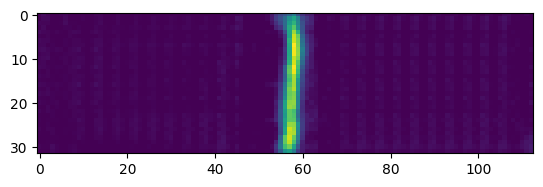

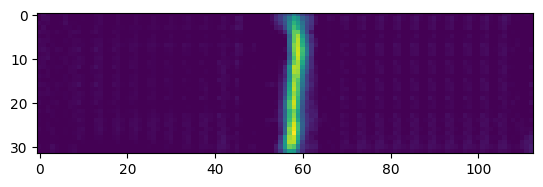

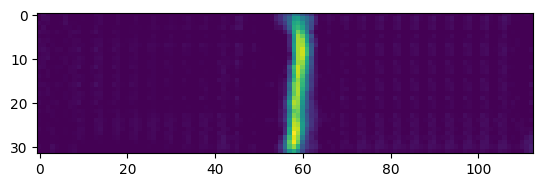

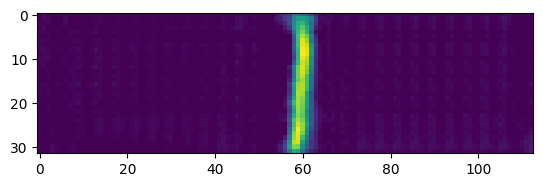

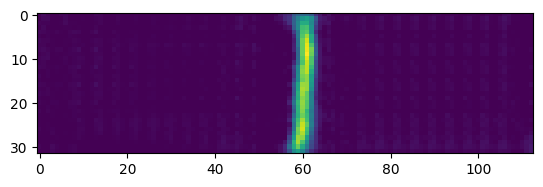

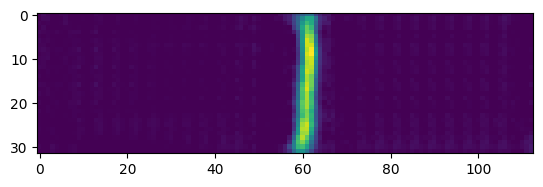

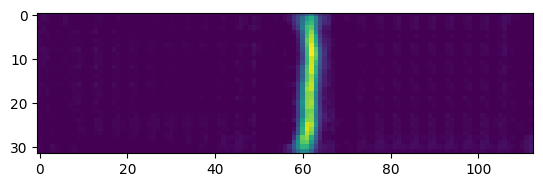

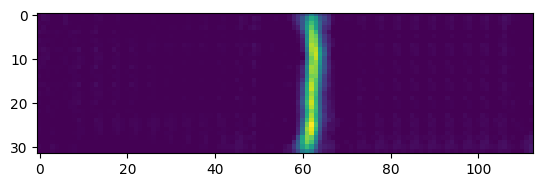

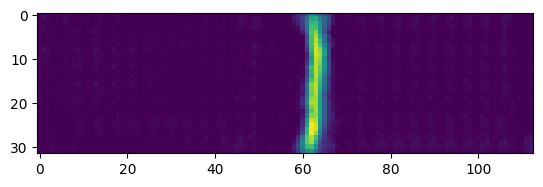

In [14]:
long = X.shape[0]

pred = np.load("/kaggle/working/work_dirs/custom_exp/saved/preds.npy")[-long:,:,:,:113,:].clip(0,1)
print(pred.shape)

inp = np.load("/kaggle/working/work_dirs/custom_exp/saved/inputs.npy")[-long:,:,:,:113,:]

idx = 5

print("input:")
for i in range(inp.shape[1]):
    plt.imshow(inp[idx,i,0,...].T)
    plt.show()
    
print("#"*25)
print("pred:")
for i in range(pred.shape[1]):
    plt.imshow(pred[idx,i,0,...].T)
    plt.show()

In [15]:
y_preds = {}
ids = []
for i,row in test_df.iterrows():
    id = row['id']
    y_preds[id]= np.array(pred[i,:,0,...]).flatten(order='C').astype(np.float32)
    ids.append(id)

df = pd.DataFrame.from_dict(y_preds,orient='index')
df['id'] = ids

#move id to first column
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
#reset index
df = df.reset_index(drop=True)

In [16]:
!rm -rf ./*

In [17]:
df.to_csv('./submission.csv',index=False)

sub = pd.read_csv('submission.csv')
sub.head()

,id,0,1,2,3,4,5,6,7,8,...,72310,72311,72312,72313,72314,72315,72316,72317,72318,72319
0,219547,0.001021,0.000000,0.000827,0.000000,0.003555,0.002226,0.003826,0.007723,0.001911,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.004556,0.000000,0.000000,0.001159
1,167403,0.001985,0.000000,0.001625,0.000000,0.003978,0.002701,0.002994,0.006746,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.004740,0.000000,0.000000,0.001240
2,225258,0.003750,0.000646,0.003263,0.001143,0.005405,0.003867,0.003264,0.008401,0.001139,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.002845,0.000000,0.000000,0.000000
3,890407,0.014363,0.000000,0.004749,0.000000,0.041414,0.013799,0.013767,0.004535,0.043824,...,0.004399,0.0,0.014074,0.001447,0.010665,0.022670,0.048866,0.042587,0.058547,0.054174
4,352206,0.014623,0.000000,0.005126,0.000000,0.043183,0.014420,0.014089,0.004174,0.041119,...,0.004865,0.0,0.014167,0.002103,0.010987,0.022603,0.047960,0.041636,0.057730,0.053158


In [18]:
!ls

__notebook__.ipynb  submission.csv
